In [249]:
!pip install xgboost

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [250]:
import pandas as pd
import numpy as np
import random
import pickle
import gc
#import psycopg2
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, r2_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [251]:
pitcher = 'Bauer'
path = '/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/pitcher_df_pickles/' + pitcher + '_df.pkl'
df = pd.read_pickle(path, compression='zip').reset_index()
df.head()

,index,pitch_type,game_date,pitcher,on_3b,on_2b,on_1b,outs_when_up,inning,catcher_id,sz_top,sz_bot,at_bat_number,pitch_number,bat_score,stand,inning_topbot,if_fielding_alignment,score_diff,bases_loaded,fastball_perc_faced,fastball_chase_perc,fastball_bip_swung_perc,fastball_taken_strike_perc,fastball_est_woba,fastball_babip,fastball_iso_value,breaking_perc_faced,breaking_chase_perc,breaking_bip_swung_perc,breaking_taken_strike_perc,breaking_est_woba,breaking_babip,breaking_iso_value,offspeed_perc_faced,offspeed_chase_perc,offspeed_bip_swung_perc,offspeed_taken_strike_perc,offspeed_est_woba,offspeed_babip,offspeed_iso_value,pitchout_perc_faced,balls,strikes,player_name,of_fielding_alignment,_count,count_cat,pitch_cat,overall_fastball_perc,count_cat_fastball_perc,overall_breaking_perc,count_cat_breaking_perc,overall_offspeed_perc,count_cat_offspeed_perc,pitch_count,L1_pitch_type,L1_pitch_result,L1_description,L1_pitch_zone,L1_batter_swung,L1_chased,L2_pitch_type,L2_pitch_result,L2_description,L2_pitch_zone,L2_chased,L3_pitch_type,L3_description,L3_pitch_zone,L3_chased,L5_fastball_perc,L15_fastball_perc,L5_breaking_perc,L15_breaking_perc,L5_offspeed_perc,L15_offspeed_perc,L5_strike_perc,L15_strike_perc,batting_order_slot,pitcher_AB,prev_ab_run_scored,prev_ab_homerun,prev_ab_walk,prev_ab_basehit,prev_ab_strikeout,PB_fastball,PB_breaking,PB_offspeed,month,year,on_base
0,12672,FF,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.4075,1.5189,1.0,1.0,0.0,L,Bot,Strategic,0.0,0,66.166039,36.658653,42.193089,29.177719,0.278596,0.290698,0.053488,25.490196,44.285713,43.85965,28.352489,0.260893,0.271795,0.082051,8.343763,46.153847,52.100842,21.686747,0.283855,0.295775,0.070423,0.0,0,0,Trevor Bauer,Standard,00,neutral,fastball,52.285535,60.526316,33.688165,27.543860,14.026299,11.929825,1.0,N/A,N/A,N/A,-1.0,-1.0,-1.0,N/A,N/A,N/A,-1.0,-1.0,N/A,N/A,-1.0,-1.0,55.157757,55.157757,37.338565,37.338565,7.503678,7.503678,47.948341,47.948341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.526316,27.543860,11.929825,4,2018,0
1,12673,FF,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.4768,1.5882,1.0,2.0,0.0,L,Bot,Strategic,0.0,0,66.166039,36.658653,42.193089,29.177719,0.278596,0.290698,0.053488,25.490196,44.285713,43.85965,28.352489,0.260893,0.271795,0.082051,8.343763,46.153847,52.100842,21.686747,0.283855,0.295775,0.070423,0.0,0,1,Trevor Bauer,Standard,01,ahead,fastball,52.285535,43.815789,33.688165,44.210526,14.026299,11.973684,2.0,FF,S,called_strike,3.0,0.0,0.0,N/A,N/A,N/A,-1.0,-1.0,N/A,N/A,-1.0,-1.0,55.157757,55.157757,37.338565,37.338565,7.503678,7.503678,47.948341,47.948341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.815789,44.210526,11.973684,4,2018,0
2,12674,FF,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.1996,1.2689,1.0,3.0,0.0,L,Bot,Strategic,0.0,0,66.166039,36.658653,42.193089,29.177719,0.278596,0.290698,0.053488,25.490196,44.285713,43.85965,28.352489,0.260893,0.271795,0.082051,8.343763,46.153847,52.100842,21.686747,0.283855,0.295775,0.070423,0.0,1,1,Trevor Bauer,Standard,11,ahead,fastball,52.285535,43.815789,33.688165,44.210526,14.026299,11.973684,3.0,FF,B,ball,12.0,0.0,0.0,FF,S,called_strike,3.0,0.0,N/A,N/A,-1.0,-1.0,55.157757,55.157757,37.338565,37.338565,7.503678,7.503678,47.948341,47.948341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.815789,44.210526,11.973684,4,2018,0
3,12675,SL,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.4248,1.5882,1.0,4.0,0.0,L,Bot,Standard,0.0,0,66.166039,36.658653,42.193089,29.177719,0.278596,0.290698,0.053488,25.490196,44.285713,43.85965,28.352489,0.260893,0.271795,0.082051,8.343763,46.153847,52.100842,21.686747,0.283855,0.295775,0.070423,0.0,1,2,Trevor Bauer,Standard,12,ahead,breaking,52.285535,43.815789,33.688165,44.210526,14.026299,11.973684,4.0,FF,S,foul,1.0,1.0,0.0,FF,B,ball,12.0,0.0,FF,called_strike,3.0,0.0,55.157757,55.157757,37.338565,37.338565,7.503678,7.503678,47.948341,47.948341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.815789,44.210526,11.973684,4,2018,0
4,12676,FT,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.2087,1.2775,1.0,5.0,0.0

In [252]:
#replace some categoricals with custom strategic ordinal encoding scale:

def custom_ordinal_ecode(df):
    df = df.copy()
        
    #description cols:
    desc_map = {'called_strike':1,
                'swinging_strike':2,
                'foul_tip':3,
                'foul':4,
                'swinging_strike_blocked':5,
                'foul_bunt':6,
                'missed_bunt':6,
                'bunt_foul_tip':6,
                'N/A':7,
                'pitchout':7,
                'hit_into_play':8,
                'ball':9,
                'blocked_ball':10,
                'hit_by_pitch':11,
                'hit_into_play_no_out':12,
                'hit_into_play_score':13}
    
    desc_cols = ['L1_description', 'L2_description', 'L3_description']
    df[desc_cols] = df[desc_cols].replace(desc_map).astype('int')

    #pitch_result cols
    pitch_result_map = {'S':1, 'N/A':2, 'X':3, 'B':4}
    result_cols = ['L1_pitch_result', 'L2_pitch_result']
    df[result_cols] = df[result_cols].replace(pitch_result_map).astype('int')

    #pitch_type cols
    pitch_type_map = {'FA':1, 'FF':1, 'FT':2, 'FC':2, 'FS':2, 'SI':2, 'SF':2, 'N/A':2.5, 'SL':3,
                      'CB':4, 'CU':4, 'SC':5, 'KC':5, 'CH':6, 'KN':7, 'EP':8, 'FO':9, 'PO':9}
    pitch_type_cols = ['L1_pitch_type', 'L2_pitch_type', 'L3_pitch_type', 'pitch_type']
    df[pitch_type_cols] = df[pitch_type_cols].replace(pitch_type_map).astype('float')

    #count_cat
    count_cat_map = {'ahead':1,'neutral':2, 'behind':3}
    df['count_cat'] = df['count_cat'].replace(count_cat_map).astype('int')

    #count
    _count_map = {'02':1, '12':2, '01':3, '22':4, '11':5, '00':6, '21':7, '32':8, '10':9, '20':10, '31':11, '30':12}
    df['_count'] = df['_count'].replace(_count_map).astype('int')

    #for swung and chased, make unknown (-1) set to 0, and 0 (didnt swing/chase) set to -1:
    swung_and_chased_cols = ['L1_batter_swung', 'L1_chased', 'L2_chased', 'L3_chased']

    def swung_chase_edit(x):
        if x == 0:
            return -1
        elif x == -1:
            return 0
        else:
            return x

    for col in swung_and_chased_cols:
        df[col] = df[col].apply(swung_chase_edit)

    #fill remaining misc categories to numerics:
    misc_map = {'L':-1, 'R':2, 'Top':-1, 'Bot': 1, 'Standard':0, 'Infield shift': 1, 'Strategic':2, '4th outfielder':3}
    df = df.replace(misc_map)

    #clean up category dtypes to ints
    df['year'] = df['year'].cat.codes
    df['catcher_id'] = df['catcher_id'].cat.codes
    
    cat_cols = ['outs_when_up', 'inning', 'at_bat_number', 'pitch_number', 'balls', 'strikes', 'pitch_count', 'L1_pitch_zone', 
                'L1_batter_swung', 'L1_chased', 'L2_pitch_zone', 'L2_chased', 'L3_pitch_zone', 'L3_chased', 'batting_order_slot', 
                'month']
    
    df[cat_cols] = df[cat_cols].astype('int')
    df[['stand', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']] = df[['stand', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']].astype('int')
    return df

def train_test_split_by_date(df, train_fraction):
    train_idx = int(len(df) * train_fraction)
    train_end_date = df.loc[train_idx].game_date
    train = df[df['game_date'] < train_end_date]
    test = df[df['game_date'] >= train_end_date]
    print('train shape: ' + str(train.shape))
    print('test shape: '+ str(test.shape))
    return train, test


df = df.replace({'FT':'FC'})

In [253]:
df.pitch_type.value_counts(normalize=True)

FF    0.372241
KC    0.230178
FC    0.179336
SL    0.143207
CH    0.075037
Name: pitch_type, dtype: float64

In [254]:
# df[df.count_cat == 1].pitch_type.value_counts(normalize=True)

In [255]:
# df[df.count_cat == 2].pitch_type.value_counts(normalize=True)

In [256]:
# df[df.count_cat == 3].pitch_type.value_counts(normalize=True)

In [257]:
df = custom_ordinal_ecode(df)

#Train-test split

# train_end_date = '2019-08-25'
# train = df[df['game_date'] < train_end_date]
# test = df[df['game_date'] == train_end_date]
# print('train shape: ' + str(train.shape))
# print('test shape: '+ str(test.shape))


train, test = train_test_split_by_date(df, 0.85)

target = 'pitch_type'

drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', target]

X = train.drop(columns=drop_cols)
X_test = test.drop(columns=drop_cols)

y = train[target]
y_test = test[target]

X.shape, X_test.shape, y.shape, y_test.shape

scale_cols = ['fastball_perc_faced', 'fastball_chase_perc', 'fastball_bip_swung_perc', 'fastball_taken_strike_perc',
              'fastball_est_woba', 'fastball_babip', 'fastball_iso_value', 'breaking_perc_faced', 'breaking_chase_perc',
              'breaking_bip_swung_perc', 'breaking_taken_strike_perc', 'breaking_est_woba', 'breaking_babip',
              'breaking_iso_value', 'offspeed_perc_faced', 'offspeed_chase_perc', 'offspeed_bip_swung_perc',
              'offspeed_taken_strike_perc', 'offspeed_est_woba', 'offspeed_babip', 'offspeed_iso_value',
              'pitchout_perc_faced', 'overall_fastball_perc', 'count_cat_fastball_perc', 'overall_breaking_perc',
              'count_cat_breaking_perc', 'overall_offspeed_perc', 'count_cat_offspeed_perc', 'L5_fastball_perc',
              'L15_fastball_perc', 'L5_breaking_perc', 'L15_breaking_perc', 'L5_offspeed_perc', 'L15_offspeed_perc',
              'L5_strike_perc', 'L15_strike_perc', 'PB_fastball', 'PB_breaking', 'PB_offspeed']

scaler = RobustScaler()

X[scale_cols] = scaler.fit_transform(X[scale_cols].values)
X_test[scale_cols] = scaler.transform(X_test[scale_cols].values)

train shape: (5093, 92)
test shape: (1024, 92)


In [258]:
#Confusion Matrix and Classification Report Function

target_names = ['4-Seam Fastball', 'Cut Fastball', 'Slider', 'Knuckle Curve', 'Changeup']
cols = ['Predicted ' + target for target in target_names]
idx = ['Actual ' + target for target in target_names]

def con_matrix_analysis(model, X, X_test, y, y_test):
  
    model.fit(X, y)
    y_pred = model.predict(X_test)
  
    print(classification_report(y_test, y_pred, target_names=target_names))

    con_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                              columns=cols,
                              index=idx)
                            
    sns.heatmap(data=con_matrix, cmap='Blues')
    plt.show();
    return con_matrix

In [259]:
best_models = pd.read_pickle('/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/best_model_pickles/Bauer_ordinal_multiclass_best_models_v1.pkl', compression='zip').reset_index(drop=True)

# best_models.sort_values('accuracy', ascending=False)
best_models.loc[40].model

LinearSVC(C=0.2, class_weight=None, dual=False, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=50,
     multi_class='ovr', penalty='l1', random_state=42, tol=1e-05,
     verbose=0)

In [260]:
#best random forest models, (1 w/ bootstrapping 1 without)
rf_model1 = best_models.loc[0].model
rf_model2 = best_models.loc[10].model

#best XGB model
xgb_model = best_models.loc[20].model

#best SVC
svc_model = best_models.loc[30].model

#probability param set to True for soft voting:
soft_svc_model = SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=2, gamma='scale', kernel='rbf',
  max_iter=2000, probability=True, random_state=42, shrinking=False,
  tol=1e-05, verbose=False)

#best LinearSVC model
linear_svc_model = best_models.loc[40].model

#best SGD model
sgd_model = best_models.loc[60].model

#best LDA model
lda_model = best_models.loc[70].model

#best logistic regression
lr_model = best_models.loc[90].model

In [261]:
svc_model

SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=2, gamma='scale', kernel='rbf',
  max_iter=2000, probability=False, random_state=42, shrinking=False,
  tol=1e-05, verbose=False)

In [262]:
hard_estimators = [('rf1', rf_model1), ('rf2', rf_model2), ('xgb', xgb_model), ('svc', svc_model), ('L_svc', linear_svc_model),
                  ('sgd', sgd_model), ('lda', lda_model), ('lr', lr_model)]

soft_estimators = [('rf1', rf_model1), ('rf2', rf_model2), ('xgb', xgb_model), ('svc', soft_svc_model), ('sgd', sgd_model), 
                  ('lda', lda_model), ('lr', lr_model)]

vclf_hard = VotingClassifier(estimators=hard_estimators, voting='hard')
vclf_soft = VotingClassifier(estimators=soft_estimators, voting='soft')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                 precision    recall  f1-score   support

4-Seam Fastball       0.46      0.78      0.58       371
   Cut Fastball       0.38      0.03      0.06       201
         Slider       0.45      0.35      0.39       181
  Knuckle Curve       0.50      0.57      0.53       214
       Changeup       1.00      0.02      0.03        57

      micro avg       0.47      0.47      0.47      1024
      macro avg       0.56      0.35      0.32      1024
   weighted avg       0.48      0.47      0.40      1024



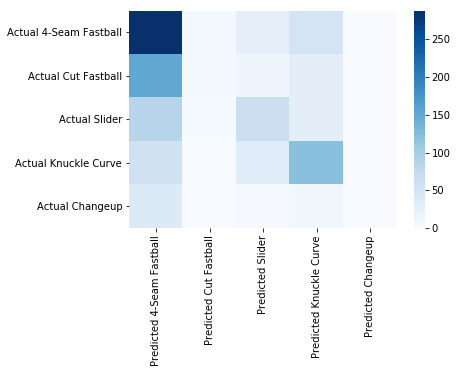

CPU times: user 22 s, sys: 1.07 s, total: 23.1 s
Wall time: 10.6 s


,Predicted 4-Seam Fastball,Predicted Cut Fastball,Predicted Slider,Predicted Knuckle Curve,Predicted Changeup
Actual 4-Seam Fastball,288,6,26,51,0
Actual Cut Fastball,152,6,13,30,0
Actual Slider,86,3,63,29,0
Actual Knuckle Curve,58,1,33,122,0
Actual Changeup,40,0,4,12,1


In [263]:
%%time
con_matrix_analysis(vclf_hard, X, X_test, y, y_test)

In [264]:
vclf_hard.fit(X, y)
accuracy_score(vclf_hard.predict(X_test), y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.46875

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


                 precision    recall  f1-score   support

4-Seam Fastball       0.46      0.77      0.58       371
   Cut Fastball       0.36      0.02      0.05       201
         Slider       0.43      0.34      0.38       181
  Knuckle Curve       0.49      0.57      0.53       214
       Changeup       1.00      0.02      0.03        57

      micro avg       0.46      0.46      0.46      1024
      macro avg       0.55      0.34      0.31      1024
   weighted avg       0.47      0.46      0.40      1024



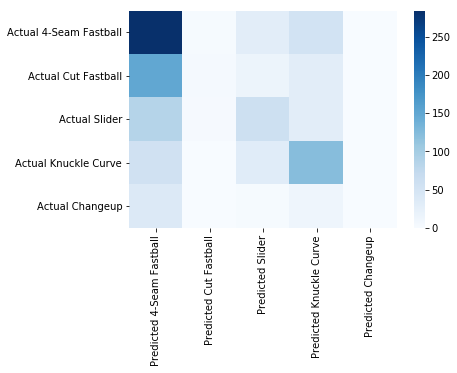

CPU times: user 40.7 s, sys: 674 ms, total: 41.4 s
Wall time: 27.2 s


,Predicted 4-Seam Fastball,Predicted Cut Fastball,Predicted Slider,Predicted Knuckle Curve,Predicted Changeup
Actual 4-Seam Fastball,284,3,30,54,0
Actual Cut Fastball,150,5,16,30,0
Actual Slider,86,4,61,30,0
Actual Knuckle Curve,57,1,33,123,0
Actual Changeup,39,1,3,13,1


In [265]:
%%time
con_matrix_analysis(vclf_soft, X, X_test, y, y_test)

                 precision    recall  f1-score   support

4-Seam Fastball       0.36      1.00      0.53       371
   Cut Fastball       0.00      0.00      0.00       201
         Slider       0.00      0.00      0.00       181
  Knuckle Curve       0.00      0.00      0.00       214
       Changeup       0.00      0.00      0.00        57

      micro avg       0.36      0.36      0.36      1024
      macro avg       0.07      0.20      0.11      1024
   weighted avg       0.13      0.36      0.19      1024



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


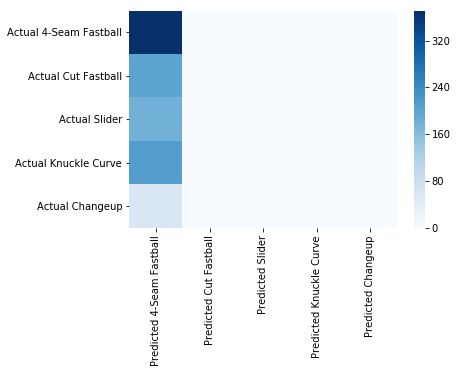

,Predicted 4-Seam Fastball,Predicted Cut Fastball,Predicted Slider,Predicted Knuckle Curve,Predicted Changeup
Actual 4-Seam Fastball,371,0,0,0,0
Actual Cut Fastball,201,0,0,0,0
Actual Slider,181,0,0,0,0
Actual Knuckle Curve,214,0,0,0,0
Actual Changeup,57,0,0,0,0


In [266]:
def naive_guess_con_matrix_analysis(y, y_test):
    #use the majority class from train set
    y_pred = [y.value_counts().index[0]]*len(y_test)
  
    print(classification_report(y_test, y_pred, target_names=target_names))

    con_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                              columns=cols,
                              index=idx)
                            
    sns.heatmap(data=con_matrix, cmap='Blues')
    plt.show();
    return con_matrix

naive_guess_con_matrix_analysis(y, y_test)

In [267]:
best_models.sort_values('accuracy', ascending=False).head(10)

,model,accuracy,balanced_accuracy,f1_score,r2_score,roc_auc_score,model_type
20,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.464844,0.340335,N/A,-0.364671,N/A,XGBClassifier
23,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.462891,0.340109,N/A,-0.391896,N/A,XGBClassifier
22,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.462891,0.340109,N/A,-0.391896,N/A,XGBClassifier
21,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.462891,0.340109,N/A,-0.391896,N/A,XGBClassifier
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.461914,0.355867,N/A,-0.354461,N/A,RandomForestClassifier
2,"(DecisionTreeClassifier(class_weight=None, cri...",0.460938,0.350100,N/A,-0.365692,N/A,RandomForestClassifier
1,"(DecisionTreeClassifier(class_weight=None, cri...",0.460938,0.348194,N/A,-0.349697,N/A,RandomForestClassifier
26,"XGBClassifier(base_score=0.5, booster='dart', ...",0.460938,0.335246,N/A,-0.385090,N/A,XGBClassifier
25,"XGBClassifier(base_score=0.5, booster='dart', ...",0.460938,0.334169,N/A,-0.390535,N/A,XGBClassifier
24,"XGBClassifier(base_score=0.5, booster='dart', ...",0.460938,0.336487,N/A,-0.385090,N/A,XGBClassifier


In [268]:
# import graphviz
# import pydotplus
# from sklearn.tree import export_graphviz

# feature_names = train.drop(columns=drop_cols).columns.tolist()
# rf_model.fit(X, y)
# estimator = rf_model.estimators_[5]


# dot_data = export_graphviz(estimator, 
#                 out_file=None, #'tree.dot', 
#                 feature_names = feature_names,
#                 class_names = ['4-Seam Fastball', '2-Seam Fastball', 'Slider', 'Knuckle Curveball', 'Changeup'],
#                 rounded = True, proportion = True, precision = 2, filled = True, rotate=False)



# pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# # pydot_graph.write_png('original_tree.png')
# pydot_graph.set_size('"5,5!"')
# pydot_graph.write_png('resized_tree.png')

# graphviz.Source(dot_data)

In [269]:
all_model_types = ['RandomForestClassifier_'+str(i) for i in range(20)] + ['XGBClassifier_'+str(i) for i in range(10)] + ['SVC_'+str(i) for i in range(10)] + ['LinearSVC_'+str(i) for i in range(20)] + ['SGDClassifier_'+str(i) for i in range(20)] + ['LinearDiscriminantAnalysis_'+str(i) for i in range(10)] + ['KNeighborsClassifier_'+str(i) for i in range(10)] + ['LogisticRegression_'+str(i) for i in range(10)] 
all_estimators = list(zip(all_model_types, best_models.model.values))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=3500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or M

                 precision    recall  f1-score   support

4-Seam Fastball       0.46      0.76      0.57       371
   Cut Fastball       0.25      0.01      0.03       201
         Slider       0.44      0.34      0.38       181
  Knuckle Curve       0.48      0.57      0.52       214
       Changeup       0.50      0.02      0.03        57

      micro avg       0.46      0.46      0.46      1024
      macro avg       0.42      0.34      0.31      1024
   weighted avg       0.42      0.46      0.39      1024



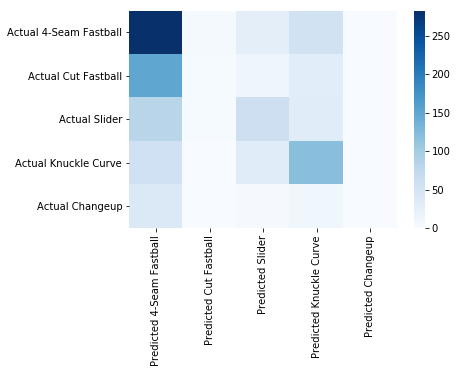

CPU times: user 8min 24s, sys: 4.27 s, total: 8min 28s
Wall time: 3min 5s


In [270]:
%%time
vclf_all = VotingClassifier(estimators=all_estimators, voting='hard')
con_matrix_analysis(vclf_all, X, X_test, y, y_test)

## Accuracy Boost: Group all Fastballs Together, and Train Separate Models for Each Count Category

In [271]:
pitcher = 'Bauer'
path = '/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/pitcher_df_pickles/' + pitcher + '_df.pkl'
df = pd.read_pickle(path, compression='zip').reset_index()
df.head()

,index,pitch_type,game_date,pitcher,on_3b,on_2b,on_1b,outs_when_up,inning,catcher_id,sz_top,sz_bot,at_bat_number,pitch_number,bat_score,stand,inning_topbot,if_fielding_alignment,score_diff,bases_loaded,fastball_perc_faced,fastball_chase_perc,fastball_bip_swung_perc,fastball_taken_strike_perc,fastball_est_woba,fastball_babip,fastball_iso_value,breaking_perc_faced,breaking_chase_perc,breaking_bip_swung_perc,breaking_taken_strike_perc,breaking_est_woba,breaking_babip,breaking_iso_value,offspeed_perc_faced,offspeed_chase_perc,offspeed_bip_swung_perc,offspeed_taken_strike_perc,offspeed_est_woba,offspeed_babip,offspeed_iso_value,pitchout_perc_faced,balls,strikes,player_name,of_fielding_alignment,_count,count_cat,pitch_cat,overall_fastball_perc,count_cat_fastball_perc,overall_breaking_perc,count_cat_breaking_perc,overall_offspeed_perc,count_cat_offspeed_perc,pitch_count,L1_pitch_type,L1_pitch_result,L1_description,L1_pitch_zone,L1_batter_swung,L1_chased,L2_pitch_type,L2_pitch_result,L2_description,L2_pitch_zone,L2_chased,L3_pitch_type,L3_description,L3_pitch_zone,L3_chased,L5_fastball_perc,L15_fastball_perc,L5_breaking_perc,L15_breaking_perc,L5_offspeed_perc,L15_offspeed_perc,L5_strike_perc,L15_strike_perc,batting_order_slot,pitcher_AB,prev_ab_run_scored,prev_ab_homerun,prev_ab_walk,prev_ab_basehit,prev_ab_strikeout,PB_fastball,PB_breaking,PB_offspeed,month,year,on_base
0,12672,FF,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.4075,1.5189,1.0,1.0,0.0,L,Bot,Strategic,0.0,0,66.166039,36.658653,42.193089,29.177719,0.278596,0.290698,0.053488,25.490196,44.285713,43.85965,28.352489,0.260893,0.271795,0.082051,8.343763,46.153847,52.100842,21.686747,0.283855,0.295775,0.070423,0.0,0,0,Trevor Bauer,Standard,00,neutral,fastball,52.285535,60.526316,33.688165,27.543860,14.026299,11.929825,1.0,N/A,N/A,N/A,-1.0,-1.0,-1.0,N/A,N/A,N/A,-1.0,-1.0,N/A,N/A,-1.0,-1.0,55.157757,55.157757,37.338565,37.338565,7.503678,7.503678,47.948341,47.948341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.526316,27.543860,11.929825,4,2018,0
1,12673,FF,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.4768,1.5882,1.0,2.0,0.0,L,Bot,Strategic,0.0,0,66.166039,36.658653,42.193089,29.177719,0.278596,0.290698,0.053488,25.490196,44.285713,43.85965,28.352489,0.260893,0.271795,0.082051,8.343763,46.153847,52.100842,21.686747,0.283855,0.295775,0.070423,0.0,0,1,Trevor Bauer,Standard,01,ahead,fastball,52.285535,43.815789,33.688165,44.210526,14.026299,11.973684,2.0,FF,S,called_strike,3.0,0.0,0.0,N/A,N/A,N/A,-1.0,-1.0,N/A,N/A,-1.0,-1.0,55.157757,55.157757,37.338565,37.338565,7.503678,7.503678,47.948341,47.948341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.815789,44.210526,11.973684,4,2018,0
2,12674,FF,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.1996,1.2689,1.0,3.0,0.0,L,Bot,Strategic,0.0,0,66.166039,36.658653,42.193089,29.177719,0.278596,0.290698,0.053488,25.490196,44.285713,43.85965,28.352489,0.260893,0.271795,0.082051,8.343763,46.153847,52.100842,21.686747,0.283855,0.295775,0.070423,0.0,1,1,Trevor Bauer,Standard,11,ahead,fastball,52.285535,43.815789,33.688165,44.210526,14.026299,11.973684,3.0,FF,B,ball,12.0,0.0,0.0,FF,S,called_strike,3.0,0.0,N/A,N/A,-1.0,-1.0,55.157757,55.157757,37.338565,37.338565,7.503678,7.503678,47.948341,47.948341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.815789,44.210526,11.973684,4,2018,0
3,12675,SL,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.4248,1.5882,1.0,4.0,0.0,L,Bot,Standard,0.0,0,66.166039,36.658653,42.193089,29.177719,0.278596,0.290698,0.053488,25.490196,44.285713,43.85965,28.352489,0.260893,0.271795,0.082051,8.343763,46.153847,52.100842,21.686747,0.283855,0.295775,0.070423,0.0,1,2,Trevor Bauer,Standard,12,ahead,breaking,52.285535,43.815789,33.688165,44.210526,14.026299,11.973684,4.0,FF,S,foul,1.0,1.0,0.0,FF,B,ball,12.0,0.0,FF,called_strike,3.0,0.0,55.157757,55.157757,37.338565,37.338565,7.503678,7.503678,47.948341,47.948341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.815789,44.210526,11.973684,4,2018,0
4,12676,FT,2018-04-01,545333.0,0.0,0.0,0.0,0.0,1.0,547379.0,3.2087,1.2775,1.0,5.0,0.0

In [272]:
df = df.replace({'FT':'FF', 'FC':'FF'})
df.pitch_type.value_counts(normalize=True)

FF    0.551578
KC    0.230178
SL    0.143207
CH    0.075037
Name: pitch_type, dtype: float64

In [273]:
df = custom_ordinal_ecode(df)

#Train-test split (use 80/20 here)
train, test = train_test_split_by_date(df, 0.80)

scale_cols = ['fastball_perc_faced', 'fastball_chase_perc', 'fastball_bip_swung_perc', 'fastball_taken_strike_perc',
              'fastball_est_woba', 'fastball_babip', 'fastball_iso_value', 'breaking_perc_faced', 'breaking_chase_perc',
              'breaking_bip_swung_perc', 'breaking_taken_strike_perc', 'breaking_est_woba', 'breaking_babip',
              'breaking_iso_value', 'offspeed_perc_faced', 'offspeed_chase_perc', 'offspeed_bip_swung_perc',
              'offspeed_taken_strike_perc', 'offspeed_est_woba', 'offspeed_babip', 'offspeed_iso_value',
              'pitchout_perc_faced', 'overall_fastball_perc', 'count_cat_fastball_perc', 'overall_breaking_perc',
              'count_cat_breaking_perc', 'overall_offspeed_perc', 'count_cat_offspeed_perc', 'L5_fastball_perc',
              'L15_fastball_perc', 'L5_breaking_perc', 'L15_breaking_perc', 'L5_offspeed_perc', 'L15_offspeed_perc',
              'L5_strike_perc', 'L15_strike_perc', 'PB_fastball', 'PB_breaking', 'PB_offspeed']

scaler = RobustScaler()

train[scale_cols] = scaler.fit_transform(train[scale_cols].values)
test[scale_cols] = scaler.transform(test[scale_cols].values)

train shape: (4872, 92)
test shape: (1245, 92)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [274]:
target = 'pitch_type'

drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', target]

train_ahead = train[train.count_cat == 1]
train_neutral = train[train.count_cat == 2]
train_behind = train[train.count_cat == 3]

test_ahead = test[test.count_cat == 1]
test_neutral = test[test.count_cat == 2]
test_behind = test[test.count_cat == 3]

X_ahead = train_ahead.drop(columns=drop_cols)
X_test_ahead = test_ahead.drop(columns=drop_cols)
y_ahead = train_ahead[target]
y_test_ahead = test_ahead[target]

X_neutral = train_neutral.drop(columns=drop_cols)
X_test_neutral = test_neutral.drop(columns=drop_cols)
y_neutral = train_neutral[target]
y_test_neutral = test_neutral[target]

X_behind = train_behind.drop(columns=drop_cols)
X_test_behind = test_behind.drop(columns=drop_cols)
y_behind = train_behind[target]
y_test_behind = test_behind[target]

#### Confirm correct shapes

In [275]:
X_ahead.shape, X_test_ahead.shape, y_ahead.shape, y_test_ahead.shape

((2380, 86), (587, 86), (2380,), (587,))

In [276]:
X_neutral.shape, X_test_neutral.shape, y_neutral.shape, y_test_neutral.shape

((1725, 86), (443, 86), (1725,), (443,))

In [277]:
X_behind.shape, X_test_behind.shape, y_behind.shape, y_test_behind.shape

((767, 86), (215, 86), (767,), (215,))

### Baseline accuracy

In [278]:
y_ahead.value_counts(normalize=True)#.index[0]

1.0    0.351261
5.0    0.342437
3.0    0.226891
6.0    0.079412
Name: pitch_type, dtype: float64

In [279]:
y_neutral.value_counts(normalize=True)

1.0    0.714203
5.0    0.165797
6.0    0.073623
3.0    0.046377
Name: pitch_type, dtype: float64

In [280]:
y_behind.value_counts(normalize=True)

1.0    0.794003
6.0    0.099087
5.0    0.071708
3.0    0.035202
Name: pitch_type, dtype: float64

In [281]:
y_test_ahead.value_counts(normalize=True)

1.0    0.369676
5.0    0.333901
3.0    0.250426
6.0    0.045997
Name: pitch_type, dtype: float64

In [282]:
y_test_neutral.value_counts(normalize=True)

1.0    0.699774
3.0    0.144470
5.0    0.110609
6.0    0.045147
Name: pitch_type, dtype: float64

In [283]:
y_test_behind.value_counts(normalize=True)

1.0    0.790698
6.0    0.093023
3.0    0.083721
5.0    0.032558
Name: pitch_type, dtype: float64

Fastball is the majority class for each count category:

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

     Fastball       0.56      1.00      0.72       697
       Slider       0.00      0.00      0.00       229
Knuckle Curve       0.00      0.00      0.00       252
     Changeup       0.00      0.00      0.00        67

    micro avg       0.56      0.56      0.56      1245
    macro avg       0.14      0.25      0.18      1245
 weighted avg       0.31      0.56      0.40      1245



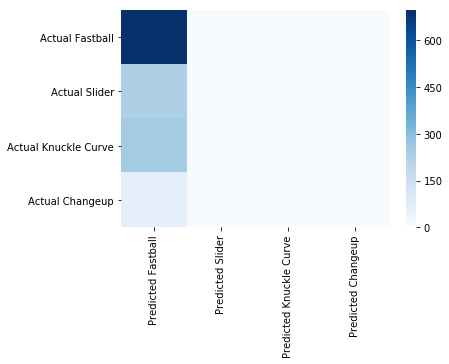

,Predicted Fastball,Predicted Slider,Predicted Knuckle Curve,Predicted Changeup
Actual Fastball,697,0,0,0
Actual Slider,229,0,0,0
Actual Knuckle Curve,252,0,0,0
Actual Changeup,67,0,0,0


In [284]:
y_combined = [1.0]*(len(y_test_ahead) + len(y_test_neutral) + len(y_test_behind))
y_test_combined = list(y_test_ahead) + list(y_test_neutral) + list(y_test_behind)

#Confusion Matrix and Classification Report Function

target_names = ['Fastball', 'Slider', 'Knuckle Curve', 'Changeup']
cols = ['Predicted ' + target for target in target_names]
idx = ['Actual ' + target for target in target_names]

def y_pred_con_matrix_analysis(y_pred, y_test):
  
    print(classification_report(y_test, y_pred, target_names=target_names))

    con_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                              columns=cols,
                              index=idx)
                            
    sns.heatmap(data=con_matrix, cmap='Blues')
    plt.show();
    return con_matrix

y_pred_con_matrix_analysis(y_combined, y_test_combined)

## Randomized Search and Voting Classifier Pipeline
#### Ahead

In [285]:
from sklearn.utils.class_weight import compute_class_weight
# classes = [1., 3., 5., 6.]
# weights = list(zip(classes, compute_class_weight('balanced', classes, y_ahead)))
# balanced_class_weight = [{weights[i][0]: weights[i][1]} for i in range(len(weights))]

num_classes = y_ahead.nunique()

estimators = [('rf', RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', )),
              ('lda', LinearDiscriminantAnalysis(solver='lsqr')), ('knn', KNeighborsClassifier()), 
              ('l1_lsvc', LinearSVC(random_state=42, verbose=50, penalty='l1', loss='squared_hinge', dual=False)),
              ('l2_lsvc', LinearSVC(random_state=42, verbose=50, penalty='l2', loss='squared_hinge', dual=True, fit_intercept=True)),
              ('xgb', XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, num_class=num_classes, objective='multi:softmax')),
              ('lr', LogisticRegression(random_state=42, n_jobs=-1, dual=False, penalty='l2'))]

vclf_ahead = VotingClassifier(estimators=estimators, voting='hard')

param_grid = {
    'rf__n_estimators': [75, 150, 300],
    'rf__max_depth': [3, 6, 9, 14, 23],
    'rf__min_samples_split': [5, 8, 12, 18, 25],
    'rf__min_samples_leaf': [3, 6, 10],
    'rf__max_features': ['auto', 0.5, 0.75, 1.0],
    'rf__class_weight': [None, 'balanced'],
    'rf__warm_start': [False, True],
    'rf__bootstrap': [True, False],
    'lda__shrinkage': [None, 'auto', 0.1, 0.5],
    'lda__tol': [0.0001, 0.00001],
    'lda__n_components':[25, 50, 85],
    'knn__n_neighbors': [4, 5, 6],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [20, 35, 50],
    'knn__p': [1,2,3],
    'l1_lsvc__tol': [0.0001, 0.00001],
    'l1_lsvc__C': [0.2, 0.8, 2.5],
    'l1_lsvc__class_weight': [None, 'balanced'],
    'l1_lsvc__max_iter': [50, 150, 400, 1000],
    'l1_lsvc__fit_intercept': [True, False],
    'l2_lsvc__tol': [0.0001, 0.00001],
    'l2_lsvc__C': [0.2, 0.8, 2.5],
    'l2_lsvc__class_weight': ['balanced', None],
    'l2_lsvc__max_iter': [50, 150, 400, 1000],
    'xgb__booster': ['gbtree', 'dart'],
    'xgb__eta': [0.15, 0.33, 0.5],
    'xgb__gamma': [6, 11, 20, 0, 3],
    'xgb__max_depth': [3, 6, 9, 14, 23],
    'xgb__min_child_weight': [0, 1, 3, 6.5],
    'xgb__max_delta_step': [1, 3, 6, 11],
    'xgb__colsample_bytree': [0.8, 0.95], 
    'xgb__colsample_bylevel': [0.8, 0.95],
    'xgb__colsample_bynode': [0.8, 0.95],
    'lr__tol': [0.0001, 0.00001],
    'lr__C': [0.5, 1.0, 2.5],
    'lr__fit_intercept': [True, False], 
    'lr__class_weight': [None, 'balanced'],
    'lr__solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'lr__max_iter': [1000, 3000, 5000, 10000, 30000],
    'lr__multi_class': ['ovr', 'auto'], 
    'lr__warm_start': [True, False]
}

search_ahead = RandomizedSearchCV(estimator=vclf_ahead, param_distributions=param_grid, n_iter=5, 
                            scoring={'Accuracy':'accuracy', 'Balanced_accuracy':'balanced_accuracy'}, n_jobs=-1, iid='warn', refit='Accuracy', cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

search_ahead.fit(X_ahead, y_ahead)
search_ahead_results = pd.DataFrame(search_ahead.cv_results_).sort_values(by='rank_test_Accuracy')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   15.0s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   22.6s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   23.1s remaining:   34.7s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   31.5s remaining:   27.5s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   39.8s remaining:   19.9s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   41.3s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   45.5s finished


[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [286]:
search_ahead_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__min_child_weight,param_xgb__max_depth,param_xgb__max_delta_step,param_xgb__gamma,param_xgb__eta,param_xgb__colsample_bytree,param_xgb__colsample_bynode,param_xgb__colsample_bylevel,param_xgb__booster,param_rf__warm_start,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__class_weight,param_rf__bootstrap,param_lr__warm_start,param_lr__tol,param_lr__solver,param_lr__multi_class,param_lr__max_iter,param_lr__fit_intercept,param_lr__class_weight,param_lr__C,param_lda__tol,param_lda__shrinkage,param_lda__n_components,param_l2_lsvc__tol,param_l2_lsvc__max_iter,param_l2_lsvc__class_weight,param_l2_lsvc__C,param_l1_lsvc__tol,param_l1_lsvc__max_iter,param_l1_lsvc__fit_intercept,param_l1_lsvc__class_weight,param_l1_lsvc__C,param_knn__weights,param_knn__p,param_knn__n_neighbors,param_knn__leaf_size,param_knn__algorithm,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,mean_train_Accuracy,std_train_Accuracy,split0_test_Balanced_accuracy,split1_test_Balanced_accuracy,split2_test_Balanced_accuracy,mean_test_Balanced_accuracy,std_test_Balanced_accuracy,rank_test_Balanced_accuracy,split0_train_Balanced_accuracy,split1_train_Balanced_accuracy,split2_train_Balanced_accuracy,mean_train_Balanced_accuracy,std_train_Balanced_accuracy
2,22.007016,0.488736,6.730070,0.609373,1,14,11,0,0.5,0.8,0.95,0.95,gbtree,False,300,8,10,0.5,6,None,True,False,1e-05,lbfgs,auto,10000,False,balanced,2.5,1e-05,0.1,25,1e-05,400,balanced,0.2,0.0001,1000,True,None,2.5,uniform,3,4,35,kd_tree,"{'xgb__min_child_weight': 1, 'xgb__max_depth':...",0.410579,0.399244,0.401515,0.403782,0.004898,1,0.656368,0.677806,0.654912,0.663029,0.010466,0.324985,0.323958,0.295036,0.314676,0.013877,1,0.569961,0.579265,0.567954,0.572393,0.004928
4,20.220124,0.321377,0.776274,0.004989,3,14,11,0,0.15,0.95,0.95,0.8,dart,True,150,5,3,auto,6,balanced,False,True,1e-05,lbfgs,ovr,3000,True,balanced,0.5,0.0001,0.5,25,1e-05,150,None,0.2,0.0001,50,True,None,2.5,uniform,1,6,50,auto,"{'xgb__min_child_weight': 3, 'xgb__max_depth':...",0.414358,0.382872,0.401515,0.399580,0.012932,2,0.656368,0.677175,0.689547,0.674363,0.013690,0.329267,0.317800,0.293449,0.313522,0.014929,2,0.583449,0.613292,0.639902,0.612214,0.023060
0,13.532106,0.354582,0.586959,0.002682,6.5,3,3,6,0.33,0.8,0.95,0.95,dart,True,300,5,3,1,9,None,False,False,0.0001,lbfgs,ovr,3000,True,balanced,0.5,1e-05,0.5,25,0.0001,150,None,0.8,1e-05,400,True,None,0.8,uniform,2,6,35,brute,"{'xgb__min_child_weight': 6.5, 'xgb__max_depth...",0.397985,0.387909,0.388889,0.391597,0.004538,3,0.627364,0.604666,0.620277,0.617436,0.009482,0.300862,0.323041,0.283526,0.302492,0.016170,3,0.511019,0.511732,0.509083,0.510611,0.001119
1,15.273498,0.972441,10.853992,0.650661,0,23,3,6,0.33,0.8,0.95,0.8,gbtree,True,300,25,6,auto,6,None,True,False,0.0001,liblinear,ovr,30000,False,balanced,0.5,0.0001,None,50,1e-05,150,balanced,0.2,0.0001,50,True,None,2.5,uniform,3,5,35,ball_tree,"{'xgb__min_child_weight': 0, 'xgb__max_depth':...",0.386650,0.385390,0.377525,0.383193,0.004036,4,0.614124,0.610971,0.608942,0.611346,0.002132,0.296810,0.326477,0.273568,0.298973,0.021649,5,0.510570,0.517568,0.521027,0.516388,0.004350
3,8.913591,0.080198,9.045409,0.532138,3,3,3,11,0.5,0.95,0.95,0.95,dart,True,150,12,10,1,3,balanced,True,True,1e-05,liblinear,auto,1000,True,None,1,1e-05,auto,25,0.0001,50,None,0.2,0.0001,400,True,None,2.5,uniform,3,4,35,kd_tree,"{'xgb__min_child_weight': 3, 'xgb__max_depth':...",0.400504,0.377834,0.367424,0.381933,0.013810,5,0.583859,0.566204,0.573048,0.574370,0.007268,0.311525,0.321801,0.265675,0.299696,0.024389,4,0.489678,0.496736,0.492845,0.493086,0.002887


In [287]:
best_ahead = search_ahead.best_estimator_
best_ahead.fit(X_ahead, y_ahead)

y_pred_ahead = search_ahead.predict(X_test_ahead)

accuracy_score(y_pred_ahead, y_test_ahead)

[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.47700170357751276

#### Neutral

In [288]:
num_classes = y_neutral.nunique()

estimators = [('rf', RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', )),
                    ('lda', LinearDiscriminantAnalysis(solver='lsqr')), ('knn', KNeighborsClassifier()), 
                    ('l1_lsvc', LinearSVC(random_state=42, verbose=50, penalty='l1', loss='squared_hinge', dual=False)),
                    ('l2_lsvc', LinearSVC(random_state=42, verbose=50, penalty='l2', loss='squared_hinge', dual=True, fit_intercept=True)),
                    ('xgb', XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, num_class=num_classes, objective='multi:softmax')),
                    ('lr', LogisticRegression(random_state=42, n_jobs=-1, dual=False, penalty='l2'))]

vclf_neutral = VotingClassifier(estimators=estimators, voting='hard')

param_grid = {
    'rf__n_estimators': [75, 150, 300],
    'rf__max_depth': [3, 6, 9, 14, 23],
    'rf__min_samples_split': [5, 8, 12, 18, 25],
    'rf__min_samples_leaf': [3, 6, 10],
    'rf__max_features': ['auto', 0.5, 0.75, 1.0],
    'rf__class_weight': [None, 'balanced'],
    'rf__warm_start': [False, True],
    'rf__bootstrap': [True, False],
    'lda__shrinkage': [None, 'auto', 0.1, 0.5],
    'lda__tol': [0.0001, 0.00001],
    'lda__n_components':[25, 50, 85],
    'knn__n_neighbors': [4, 5, 6],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [20, 35, 50],
    'knn__p': [1,2,3],
    'l1_lsvc__tol': [0.0001, 0.00001],
    'l1_lsvc__C': [0.2, 0.8, 2.5],
    'l1_lsvc__class_weight': [None, 'balanced'],
    'l1_lsvc__max_iter': [50, 150, 400, 1000],
    'l1_lsvc__fit_intercept': [True, False],
    'l2_lsvc__tol': [0.0001, 0.00001],
    'l2_lsvc__C': [0.2, 0.8, 2.5],
    'l2_lsvc__class_weight': ['balanced', None],
    'l2_lsvc__max_iter': [50, 150, 400, 1000],
    'xgb__booster': ['gbtree', 'dart'],
    'xgb__eta': [0.15, 0.33, 0.5],
    'xgb__gamma': [6, 11, 20, 0, 3],
    'xgb__max_depth': [3, 6, 9, 14, 23],
    'xgb__min_child_weight': [0, 1, 3, 6.5],
    'xgb__max_delta_step': [1, 3, 6, 11],
    'xgb__colsample_bytree': [0.8, 0.95], 
    'xgb__colsample_bylevel': [0.8, 0.95],
    'xgb__colsample_bynode': [0.8, 0.95],
    'lr__tol': [0.0001, 0.00001],
    'lr__C': [0.5, 1.0, 2.5],
    'lr__fit_intercept': [True, False], 
    'lr__class_weight': [None, 'balanced'],
    'lr__solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'lr__max_iter': [1000, 3000, 5000, 10000, 30000],
    'lr__multi_class': ['ovr', 'auto'], 
    'lr__warm_start': [True, False]
}

search_neutral = RandomizedSearchCV(estimator=vclf_neutral, param_distributions=param_grid, n_iter=5, 
                            scoring={'Accuracy':'accuracy', 'Balanced_accuracy':'balanced_accuracy'}, n_jobs=-1, iid='warn', refit='Accuracy', cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

search_neutral.fit(X_neutral, y_neutral)
search_neutral_results = pd.DataFrame(search_neutral.cv_results_).sort_values(by='rank_test_Accuracy')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   11.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   13.6s remaining:   37.3s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   14.2s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   17.2s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   22.8s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   23.0s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   23.5s finished


[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [289]:
search_neutral_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__min_child_weight,param_xgb__max_depth,param_xgb__max_delta_step,param_xgb__gamma,param_xgb__eta,param_xgb__colsample_bytree,param_xgb__colsample_bynode,param_xgb__colsample_bylevel,param_xgb__booster,param_rf__warm_start,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__class_weight,param_rf__bootstrap,param_lr__warm_start,param_lr__tol,param_lr__solver,param_lr__multi_class,param_lr__max_iter,param_lr__fit_intercept,param_lr__class_weight,param_lr__C,param_lda__tol,param_lda__shrinkage,param_lda__n_components,param_l2_lsvc__tol,param_l2_lsvc__max_iter,param_l2_lsvc__class_weight,param_l2_lsvc__C,param_l1_lsvc__tol,param_l1_lsvc__max_iter,param_l1_lsvc__fit_intercept,param_l1_lsvc__class_weight,param_l1_lsvc__C,param_knn__weights,param_knn__p,param_knn__n_neighbors,param_knn__leaf_size,param_knn__algorithm,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,mean_train_Accuracy,std_train_Accuracy,split0_test_Balanced_accuracy,split1_test_Balanced_accuracy,split2_test_Balanced_accuracy,mean_test_Balanced_accuracy,std_test_Balanced_accuracy,rank_test_Balanced_accuracy,split0_train_Balanced_accuracy,split1_train_Balanced_accuracy,split2_train_Balanced_accuracy,mean_train_Balanced_accuracy,std_train_Balanced_accuracy
2,14.512265,0.138655,3.106681,0.201032,1,14,11,0,0.5,0.8,0.95,0.95,gbtree,False,300,8,10,0.5,6,None,True,False,1e-05,lbfgs,auto,10000,False,balanced,2.5,1e-05,0.1,25,1e-05,400,balanced,0.2,0.0001,1000,True,None,2.5,uniform,3,4,35,kd_tree,"{'xgb__min_child_weight': 1, 'xgb__max_depth':...",0.684575,0.650435,0.680628,0.671884,0.015252,1,0.810976,0.793043,0.783854,0.795958,0.011262,0.324095,0.242229,0.328630,0.298313,0.039700,5,0.484542,0.470275,0.420450,0.458422,0.027475
0,10.219045,0.547329,0.532110,0.024333,6.5,3,3,6,0.33,0.8,0.95,0.95,dart,True,300,5,3,1,9,None,False,False,0.0001,lbfgs,ovr,3000,True,balanced,0.5,1e-05,0.5,25,0.0001,150,None,0.8,1e-05,400,True,None,0.8,uniform,2,6,35,brute,"{'xgb__min_child_weight': 6.5, 'xgb__max_depth...",0.681109,0.613913,0.673647,0.656232,0.030079,2,0.769164,0.786957,0.752604,0.769575,0.014027,0.322879,0.254152,0.331533,0.302845,0.034612,3,0.357083,0.459857,0.338715,0.385218,0.053307
4,12.450627,0.286086,0.508409,0.018910,3,14,11,0,0.15,0.95,0.95,0.8,dart,True,150,5,3,auto,6,balanced,False,True,1e-05,lbfgs,ovr,3000,True,balanced,0.5,0.0001,0.5,25,1e-05,150,None,0.2,0.0001,50,True,None,2.5,uniform,1,6,50,auto,"{'xgb__min_child_weight': 3, 'xgb__max_depth':...",0.651646,0.652174,0.642234,0.648696,0.004562,3,0.815331,0.814783,0.871528,0.833880,0.026622,0.348464,0.253525,0.406647,0.336145,0.063065,1,0.503755,0.528790,0.659918,0.564155,0.068482
1,9.763224,0.186900,5.396497,0.321666,0,23,3,6,0.33,0.8,0.95,0.8,gbtree,True,300,25,6,auto,6,None,True,False,0.0001,liblinear,ovr,30000,False,balanced,0.5,0.0001,None,50,1e-05,150,balanced,0.2,0.0001,50,True,None,2.5,uniform,3,5,35,ball_tree,"{'xgb__min_child_weight': 0, 'xgb__max_depth':...",0.623917,0.638261,0.663176,0.641739,0.016215,4,0.775261,0.761739,0.750868,0.762623,0.009978,0.360687,0.248659,0.294139,0.301239,0.046048,4,0.417991,0.386760,0.361706,0.388819,0.023024
3,6.805710,0.106750,4.308381,0.354287,3,3,3,11,0.5,0.95,0.95,0.95,dart,True,150,12,10,1,3,balanced,True,True,1e-05,liblinear,auto,1000,True,None,1,1e-05,auto,25,0.0001,50,None,0.2,0.0001,400,True,None,2.5,uniform,3,4,35,kd_tree,"{'xgb__min_child_weight': 3, 'xgb__max_depth':...",0.655113,0.627826,0.598604,0.627246,0.023073,5,0.780488,0.780000,0.760417,0.773635,0.009349,0.321738,0.263065,0.409111,0.331203,0.059948,2,0.451762,0.484362,0.423710,0.453278,0.024784


In [290]:
best_neutral = search_neutral.best_estimator_
best_neutral.fit(X_neutral, y_neutral)

y_pred_neutral = best_neutral.predict(X_test_neutral)
accuracy_score(y_pred_neutral, y_test_neutral)

[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6997742663656885

#### Behind

In [291]:
num_classes = y_behind.nunique()

estimators = [('rf', RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', )),
                    ('lda', LinearDiscriminantAnalysis(solver='lsqr')), ('knn', KNeighborsClassifier()), 
                    ('l1_lsvc', LinearSVC(random_state=42, verbose=50, penalty='l1', loss='squared_hinge', dual=False)),
                    ('l2_lsvc', LinearSVC(random_state=42, verbose=50, penalty='l2', loss='squared_hinge', dual=True, fit_intercept=True)),
                    ('xgb', XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, num_class=num_classes, objective='multi:softmax')),
                    ('lr', LogisticRegression(random_state=42, n_jobs=-1, dual=False, penalty='l2'))]

vclf_behind = VotingClassifier(estimators=estimators, voting='hard')

param_grid = {
    'rf__n_estimators': [75, 150, 300],
    'rf__max_depth': [3, 6, 9, 14, 23],
    'rf__min_samples_split': [5, 8, 12, 18, 25],
    'rf__min_samples_leaf': [3, 6, 10],
    'rf__max_features': ['auto', 0.5, 0.75, 1.0],
    'rf__class_weight': [None, 'balanced'],
    'rf__warm_start': [False, True],
    'rf__bootstrap': [True, False],
    'lda__shrinkage': [None, 'auto', 0.1, 0.5],
    'lda__tol': [0.0001, 0.00001],
    'lda__n_components':[25, 50, 85],
    'knn__n_neighbors': [4, 5, 6],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [20, 35, 50],
    'knn__p': [1,2,3],
    'l1_lsvc__tol': [0.0001, 0.00001],
    'l1_lsvc__C': [0.2, 0.8, 2.5],
    'l1_lsvc__class_weight': [None, 'balanced'],
    'l1_lsvc__max_iter': [50, 150, 400, 1000],
    'l1_lsvc__fit_intercept': [True, False],
    'l2_lsvc__tol': [0.0001, 0.00001],
    'l2_lsvc__C': [0.2, 0.8, 2.5],
    'l2_lsvc__class_weight': ['balanced', None],
    'l2_lsvc__max_iter': [50, 150, 400, 1000],
    'xgb__booster': ['gbtree', 'dart'],
    'xgb__eta': [0.15, 0.33, 0.5],
    'xgb__gamma': [6, 11, 20, 0, 3],
    'xgb__max_depth': [3, 6, 9, 14, 23],
    'xgb__min_child_weight': [0, 1, 3, 6.5],
    'xgb__max_delta_step': [1, 3, 6, 11],
    'xgb__colsample_bytree': [0.8, 0.95], 
    'xgb__colsample_bylevel': [0.8, 0.95],
    'xgb__colsample_bynode': [0.8, 0.95],
    'lr__tol': [0.0001, 0.00001],
    'lr__C': [0.5, 1.0, 2.5],
    'lr__fit_intercept': [True, False], 
    'lr__class_weight': [None, 'balanced'],
    'lr__solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'lr__max_iter': [1000, 3000, 5000, 10000, 30000],
    'lr__multi_class': ['ovr', 'auto'], 
    'lr__warm_start': [True, False]
}

search_behind = RandomizedSearchCV(estimator=vclf_behind, param_distributions=param_grid, n_iter=5, 
                            scoring={'Accuracy':'accuracy', 'Balanced_accuracy':'balanced_accuracy'}, n_jobs=-1, iid='warn', refit='Accuracy', cv=3, verbose=10, 
                            random_state=42, error_score='raise-deprecating', return_train_score=True)

search_behind.fit(X_behind, y_behind)
search_behind_results = pd.DataFrame(search_behind.cv_results_).sort_values(by='rank_test_Accuracy')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    6.0s remaining:   39.0s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    6.5s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    7.2s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    7.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    8.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.7s finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

In [292]:
search_behind_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__min_child_weight,param_xgb__max_depth,param_xgb__max_delta_step,param_xgb__gamma,param_xgb__eta,param_xgb__colsample_bytree,param_xgb__colsample_bynode,param_xgb__colsample_bylevel,param_xgb__booster,param_rf__warm_start,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__class_weight,param_rf__bootstrap,param_lr__warm_start,param_lr__tol,param_lr__solver,param_lr__multi_class,param_lr__max_iter,param_lr__fit_intercept,param_lr__class_weight,param_lr__C,param_lda__tol,param_lda__shrinkage,param_lda__n_components,param_l2_lsvc__tol,param_l2_lsvc__max_iter,param_l2_lsvc__class_weight,param_l2_lsvc__C,param_l1_lsvc__tol,param_l1_lsvc__max_iter,param_l1_lsvc__fit_intercept,param_l1_lsvc__class_weight,param_l1_lsvc__C,param_knn__weights,param_knn__p,param_knn__n_neighbors,param_knn__leaf_size,param_knn__algorithm,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,mean_train_Accuracy,std_train_Accuracy,split0_test_Balanced_accuracy,split1_test_Balanced_accuracy,split2_test_Balanced_accuracy,mean_test_Balanced_accuracy,std_test_Balanced_accuracy,rank_test_Balanced_accuracy,split0_train_Balanced_accuracy,split1_train_Balanced_accuracy,split2_train_Balanced_accuracy,mean_train_Balanced_accuracy,std_train_Balanced_accuracy
0,5.603187,0.115111,0.455991,0.004191,6.5,3,3,6,0.33,0.8,0.95,0.95,dart,True,300,5,3,1,9,None,False,False,0.0001,lbfgs,ovr,3000,True,balanced,0.5,1e-05,0.5,25,0.0001,150,None,0.8,1e-05,400,True,None,0.8,uniform,2,6,35,brute,"{'xgb__min_child_weight': 6.5, 'xgb__max_depth...",0.789883,0.792157,0.780392,0.787484,0.005090,1,0.839216,0.822266,0.830078,0.830520,0.006927,0.261926,0.248768,0.253842,0.254864,0.005423,5,0.429384,0.350777,0.395778,0.391980,0.032203
2,6.014078,0.087267,1.044995,0.075908,1,14,11,0,0.5,0.8,0.95,0.95,gbtree,False,300,8,10,0.5,6,None,True,False,1e-05,lbfgs,auto,10000,False,balanced,2.5,1e-05,0.1,25,1e-05,400,balanced,0.2,0.0001,1000,True,None,2.5,uniform,3,4,35,kd_tree,"{'xgb__min_child_weight': 1, 'xgb__max_depth':...",0.770428,0.788235,0.760784,0.773142,0.011357,2,0.903922,0.865234,0.919922,0.896359,0.022958,0.303474,0.247537,0.282759,0.277990,0.023097,4,0.671268,0.524245,0.740527,0.645347,0.090179
1,3.806063,0.205868,1.738060,0.121926,0,23,3,6,0.33,0.8,0.95,0.8,gbtree,True,300,25,6,auto,6,None,True,False,0.0001,liblinear,ovr,30000,False,balanced,0.5,0.0001,None,50,1e-05,150,balanced,0.2,0.0001,50,True,None,2.5,uniform,3,5,35,ball_tree,"{'xgb__min_child_weight': 0, 'xgb__max_depth':...",0.750973,0.792157,0.760784,0.767927,0.017563,3,0.837255,0.832031,0.861328,0.843538,0.012759,0.368875,0.274083,0.282759,0.308729,0.042842,3,0.439819,0.428667,0.517321,0.461936,0.039427
4,5.332143,0.060619,0.297346,0.023484,3,14,11,0,0.15,0.95,0.95,0.8,dart,True,150,5,3,auto,6,balanced,False,True,1e-05,lbfgs,ovr,3000,True,balanced,0.5,0.0001,0.5,25,1e-05,150,None,0.2,0.0001,50,True,None,2.5,uniform,1,6,50,auto,"{'xgb__min_child_weight': 3, 'xgb__max_depth':...",0.778210,0.776471,0.729412,0.761408,0.022592,4,0.905882,0.904297,0.927734,0.912638,0.010694,0.377495,0.252611,0.316749,0.315780,0.051021,2,0.714384,0.697762,0.764039,0.725395,0.028155
3,2.982345,0.175751,1.060236,0.082480,3,3,3,11,0.5,0.95,0.95,0.95,dart,True,150,12,10,1,3,balanced,True,True,1e-05,liblinear,auto,1000,True,None,1,1e-05,auto,25,0.0001,50,None,0.2,0.0001,400,True,None,2.5,uniform,3,4,35,kd_tree,"{'xgb__min_child_weight': 3, 'xgb__max_depth':...",0.723735,0.764706,0.729412,0.739244,0.018118,5,0.868627,0.863281,0.894531,0.875480,0.013647,0.407960,0.270342,0.325517,0.334798,0.056598,1,0.592731,0.559739,0.636188,0.596219,0.031308


In [293]:
best_behind = search_behind.best_estimator_
best_behind.fit(X_behind, y_behind)

y_pred_behind = best_behind.predict(X_test_behind)
accuracy_score(y_pred_behind, y_test_behind)

[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

0.8

## Combine all count categories together:

In [297]:
y_pred_combined = list(y_pred_ahead) + list(y_pred_neutral) + list(y_pred_behind)
y_test_combined = list(y_test_ahead) + list(y_test_neutral) + list(y_pred_behind)

accuracy_score(y_pred_combined, y_test_combined)

0.6465863453815262

               precision    recall  f1-score   support

     Fastball       0.69      0.89      0.78       737
       Slider       0.47      0.27      0.35       211
Knuckle Curve       0.55      0.35      0.43       249
     Changeup       0.33      0.02      0.04        48

    micro avg       0.65      0.65      0.65      1245
    macro avg       0.51      0.38      0.40      1245
 weighted avg       0.61      0.65      0.61      1245



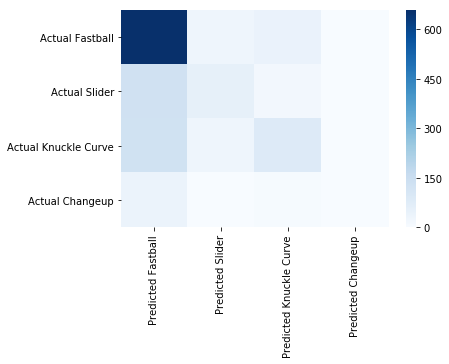

,Predicted Fastball,Predicted Slider,Predicted Knuckle Curve,Predicted Changeup
Actual Fastball,659,32,44,2
Actual Slider,133,58,20,0
Actual Knuckle Curve,129,33,87,0
Actual Changeup,40,1,6,1


In [298]:
y_pred_con_matrix_analysis(y_pred_combined, y_test_combined)